In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import  QuantumCircuit, QuantumRegister, transpile,IBMQ
from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I,Y


from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,Sampler
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit_aer.noise import NoiseModel

from qiskit.primitives import Sampler

import util_copy
import statistics

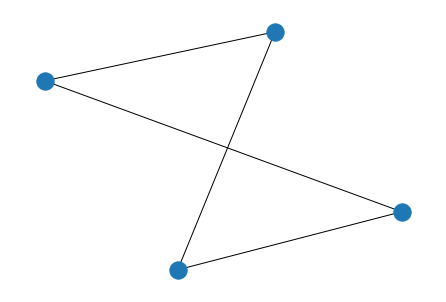

In [2]:
g = nx.Graph()
 
g.add_edge(0, 1)
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(0, 3)

nx.draw(g)
plt.show()

In [3]:
def Ising_PBC_dual(g,h):
  E = Z^Z
  B1 = X^I
  B2 = I^X


  H=(h*B1) + \
    (h*B2) + \
    (g*E) 
  return H

In [4]:
from qiskit.opflow import X, Z, I,Y


def Ising_PBC_dual(g,h):
  E1 = Z^Z^I^I
  E2 = I^Z^Z^I
  E3 = I^I^Z^Z
  E4 = Z^I^I^Z
  B1 = X^I^I^I
  B2 = I^X^I^I
  B3 = I^I^X^I
  B4 = I^I^I^X


  H=(h*B1) + \
    (h*B2) + \
    (h*B3) + \
    (h*B4) + \
    (g*E1) + \
    (g*E2) + \
    (g*E3) + \
    (g*E4) 
  return H

In [5]:
g=1
h=1
edge_list=[[0,1],[2,3],[1,2],[0,3]]
initial_layout=[4,5,6,3]

In [6]:
def ansatz_ising(num_qubits,measure_list,depth):
  theta = ParameterVector("t",depth*(len(measure_list)+2*num_qubits))
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  circuit.x(qr[i] for i in range (0,num_qubits))
  circuit.h(qr[i] for i in range (0,num_qubits))
  for _ in range (0,depth): 
    for edge in measure_list:
      circuit.cx(qr[edge[1]],qr[edge[0]])
      circuit.rz(theta[index],qr[edge[0]])
      circuit.cx(qr[edge[1]],qr[edge[0]])
    index+=1
    circuit.barrier()
    for i in range (0,num_qubits):
      circuit.rx(theta[index], qr[i])
      index+=1
  #circuit=transpile(circuit,optimization_level=3,coupling_map=[[0,1],[1,2],[1,3]],basis_gates=['cx', 'id', 'rz', 'sx', 'x'])
  print(circuit.count_ops())
  return circuit


In [12]:

provider = IBMQ.enable_account('c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51')

IBMQ.update_account()
print(IBMQ.providers())
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
ansatz=ansatz_ising(4,edge_list,2)
ansatz=transpile(ansatz,optimization_level=3,backend = provider.get_backend('ibmq_belem'))
ansatz.draw()

Found 1 credentials.
No credentials available for updating could be found. No action will be performed.
Warnings:
The stored account with url "https://auth.quantum-computing.ibm.com/api" is already an IBM Q Experience v2 account.
[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>]
OrderedDict([('cx', 16), ('rz', 8), ('rx', 8), ('x', 4), ('h', 4), ('barrier', 2)])


global phase: π
               ┌─────────┐┌────┐┌──────────┐┌───┐┌──────────┐┌───┐          »
     q0_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├┤ X ├┤ Rz(t[0]) ├┤ X ├──────────»
               ├─────────┤├────┤├──────────┤└─┬─┘└──────────┘└─┬─┘     ┌───┐»
     q0_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├──■────────────────■────■──┤ X ├»
               └─────────┘└────┘└──────────┘                        │  └─┬─┘»
ancilla_0 -> 2 ─────────────────────────────────────────────────────┼────┼──»
               ┌─────────┐┌────┐┌──────────┐                      ┌─┴─┐  │  »
     q0_3 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├──■────────────────■──┤ X ├──■──»
               ├─────────┤├────┤├──────────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘     »
     q0_2 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├┤ X ├┤ Rz(t[0]) ├┤ X ├──────────»
               └─────────┘└────┘└──────────┘└───┘└──────────┘└───┘          »
«                    ┌───┐┌──────────┐┌───┐ ░ ┌─────────┐┌────┐┌──────────────┐»
«     q0_0 -> 0 ─────┤ X ├┤ Rz(t[0]) ├┤ X ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(t[1] + π) ├»
«                    └─┬─┘└──────────┘└─┬─┘ ░ ├─────────┤├────┤├──────────────┤»
«     q0_1 -> 1 ──■────■────────────────■───░─┤ Rz(π/2) ├┤ √X ├┤ Rz(t[4] + π) ├»
«                 │                         ░ └─────────┘└────┘└──────────────┘»
«ancilla_0 -> 2 ──┼────────────────────────────────────────────────────────────»
«               ┌─┴─┐┌───┐┌──────────┐┌───┐ ░ ┌─────────┐┌────┐┌──────────────┐»
«     q0_3 -> 3 ┤ X ├┤ X ├┤ Rz(t[0]) ├┤ X ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(t[2] + π) ├»
«               └───┘└─┬─┘└──────────┘└─┬─┘ ░ ├─────────┤├────┤├──────────────┤»
«     q0_2 -> 4 ───────■────────────────■───░─┤ Rz(π/2) ├┤ √X ├┤ Rz(t[3] + π) ├»
«                                           ░ └─────────┘└────┘└──────────────┘»
«               ┌────┐┌──────────┐               ┌───┐┌──────────┐┌───┐     »
«     q0_0 -> 0 ┤ √X ├┤ Rz(5π/2) ├───────────────┤ X ├┤ Rz(t[5]) ├┤ X ├─────»
«               ├────┤├──────────┤┌───┐     ┌───┐└─┬─┘└──────────┘└─┬─┘     »
«     q0_1 -> 1 ┤ √X ├┤ Rz(5π/2) ├┤ X ├──■──┤ X ├──■────────────────■────■──»
«               └────┘└──────────┘└─┬─┘  │  └─┬─┘                        │  »
«ancilla_0 -> 2 ────────────────────┼────┼────┼──────────────────────────┼──»
«               ┌────┐┌──────────┐  │  ┌─┴─┐  │                        ┌─┴─┐»
«     q0_3 -> 3 ┤ √X ├┤ Rz(5π/2) ├──■──┤ X ├──■────■────────────────■──┤ X ├»
«               ├────┤├──────────┤     └───┘     ┌─┴─┐┌──────────┐┌─┴─┐└───┘»
«     q0_2 -> 4 ┤ √X ├┤ Rz(5π/2) ├───────────────┤ X ├┤ Rz(t[5]) ├┤ X ├─────»
«               └────┘└──────────┘               └───┘└──────────┘└───┘     »
«                         ┌───┐┌──────────┐┌───┐ ░ ┌─────────┐┌────┐»
«     q0_0 -> 0 ──────────┤ X ├┤ Rz(t[5]) ├┤ X ├─░─┤ Rz(π/2) ├┤ √X ├»
«               ┌───┐     └─┬─┘└──────────┘└─┬─┘ ░ ├─────────┤├────┤»
«     q0_1 -> 1 ┤ X ├──■────■────────────────■───░─┤ Rz(π/2) ├┤ √X ├»
«               └─┬─┘  │                         ░ └─────────┘└────┘»
«ancilla_0 -> 2 ──┼────┼────────────────────────────────────────────»
«                 │  ┌─┴─┐┌───┐┌──────────┐┌───┐ ░ ┌─────────┐┌────┐»
«     q0_3 -> 3 ──■──┤ X ├┤ X ├┤ Rz(t[5]) ├┤ X ├─░─┤ Rz(π/2) ├┤ √X ├»
«                    └───┘└─┬─┘└──────────┘└─┬─┘ ░ ├─────────┤├────┤»
«     q0_2 -> 4 ────────────■────────────────■───░─┤ Rz(π/2) ├┤ √X ├»
«                                                ░ └─────────┘└────┘»
«               ┌──────────────┐┌────┐┌──────────┐
«     q0_0 -> 0 ┤ Rz(t[6] + π) ├┤ √X ├┤ Rz(5π/2) ├
«               ├──────────────┤├────┤├──────────┤
«     q0_1 -> 1 ┤ Rz(t[9] + π) ├┤ √X ├┤ Rz(5π/2) ├
«               └──────────────┘└────┘└──────────┘
«ancilla_0 -> 2 ──────────────────────────────────
«               ┌──────────────┐┌────┐┌──────────┐
«     q0_3 -> 3 ┤ Rz(t[7] + π) ├┤ √X ├┤ Rz(5π/2) ├
«               ├──────────────┤├────┤├──────────┤
«     q0_2 -> 4 ┤ Rz(t[8] + π) ├┤ √X ├┤ Rz(5π/2) ├
«               └──────────────┘└────┘└──────────┘

In [13]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(Ising_PBC_dual(1,1))
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy_ising= np.round(exact_result.eigenvalues[0], 4)

[-5.22625186e+00 -4.82842712e+00 -2.16478440e+00 -2.00000000e+00
 -2.00000000e+00 -8.28427125e-01 -3.80801243e-16 -1.39552899e-16
  1.09855663e-16  1.65949938e-15  8.28427125e-01  2.00000000e+00
  2.00000000e+00  2.16478440e+00  4.82842712e+00  5.22625186e+00]


In [14]:
from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP,NFT

spsa = SPSA(maxiter=5,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=0,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=30, disp=True, rhobeg=1.0, tol=1e-7, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)
nft=NFT(maxiter=50, maxfev=1024, disp=True, reset_interval=100, options=None)

In [15]:

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class Miti_CustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,level_miti,time,callback=None,meas_fitt=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._level_miti=level_miti
        self._callback = callback
        self._time=time
        self._meas_fitters=meas_fitt
        
    def compute_minimum_eigenvalue(self,ham):
                
        # Define objective function to classically minimize over
        def objective(x):
            qc_cal_bound=transpile(self._circuit.assign_parameters(x),basis_gates=['cx', 'id', 'rz', 'sx', 'x'],optimization_level=0)
            if self._meas_fitters is None or (time()-self._time)>180:
                energy_mean,energy_error,meas_fit=util_copy.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti)
                self._meas_fitters=meas_fit
                self._time=time()
                print(meas_fit)
            else:
                print('nocalib')
                print(self._meas_fitters)
                energy_mean,energy_error=util_copy.estimator_meas(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti,meas_fitters=self._meas_fitters)
            energy_mean=energy_mean.real
            energy_error=energy_error.real
            print('miti_sampler')
            print(energy_mean,energy_error)
            estimator_ideal = Estimator([self._circuit], [ham])
            job = estimator_ideal.run([self._circuit], [ham], [x])
            est_result = job.result()
            print('ideal_energy')
            print(est_result.values[0])

            if self._callback is not None:
                data=[energy_mean,energy_error,est_result.values[0],x]
                self._callback(data)  
            return energy_mean
            
        # Select an initial point for the ansatzs' parameters

       # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [11]:


# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback

        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            estimator_ideal = Estimator([self._circuit], [operators])
            job = estimator_ideal.run([self._circuit], [operators], [x])
            ideal_result = job.result().values[0]
            print('ideal_energy')
            print(ideal_result)

            # Save result information using callback function
            if self._callback is not None:

                self._callback([value,ideal_result,x])
                print('miti_energy')
                print(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [18]:
options = Options()
options.resilience_level = 0
options.optimization_level = 0
options.initial_layout=initial_layout
options.shots=20000
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()


# Setup VQE algorithm
custom_vqe = Miti_CustomVQE(estimator,ansatz,cobyla,level_miti=1,time=time(),callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

OrderedDict([('u1', 40), ('cx', 25), ('u3', 20), ('barrier', 2), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 42), ('cx', 24), ('u3', 20), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('cx', 24), ('u3', 21), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('cx', 26), ('u3', 20), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('cx', 26), ('u3', 21), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 40), ('cx', 25), ('u3', 20), ('barrier', 2), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 42), ('cx', 24), ('u3', 20), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('cx', 24), ('u3', 21), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('cx', 26), ('u3', 20), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('cx', 26), ('u3', 21), ('barrier', 2), ('measure', 1)])
OrderedDict([('u

ValueError: pvals < 0, pvals > 1 or pvals contains NaNs

In [8]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_jakarta'
options = Options()
options.resilience_level = 0
options.optimization_level = 0
options.initial_layout=initial_layout
options.shots=20000

In [14]:
# Define a simple callback function
intermediate_info_real_backend_1= []
def callback(value):
        intermediate_info_real_backend_1.append(value)

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=1,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


OrderedDict([('u1', 40), ('u3', 24), ('cx', 16), ('barrier', 2), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 40), ('u3', 24), ('cx', 16), ('barrier', 2), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


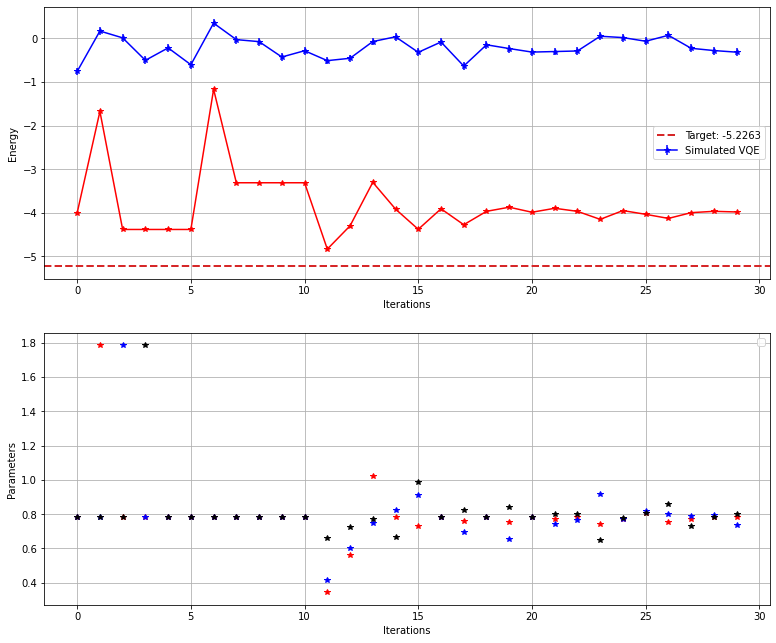

In [15]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_1:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()



In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.78717
0.14592967190690567


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_2= []
def callback(value):
        intermediate_info_real_backend_2.append(value)

options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=2,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


OrderedDict([('u1', 11), ('u3', 8), ('cx', 2), ('barrier', 1), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 8), ('cx', 2), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 9), ('cx', 2), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 8), ('cx', 2), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 9), ('cx', 2), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 11), ('u3', 8), ('cx', 2), ('barrier', 1), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 8), ('cx', 2), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 9), ('cx', 2), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 8), ('cx', 2), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 10), ('u3', 9), ('cx', 2), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 11), ('u3', 8), ('cx', 2), ('measure', 2), ('barrier', 1)])
OrderedDict([('measu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


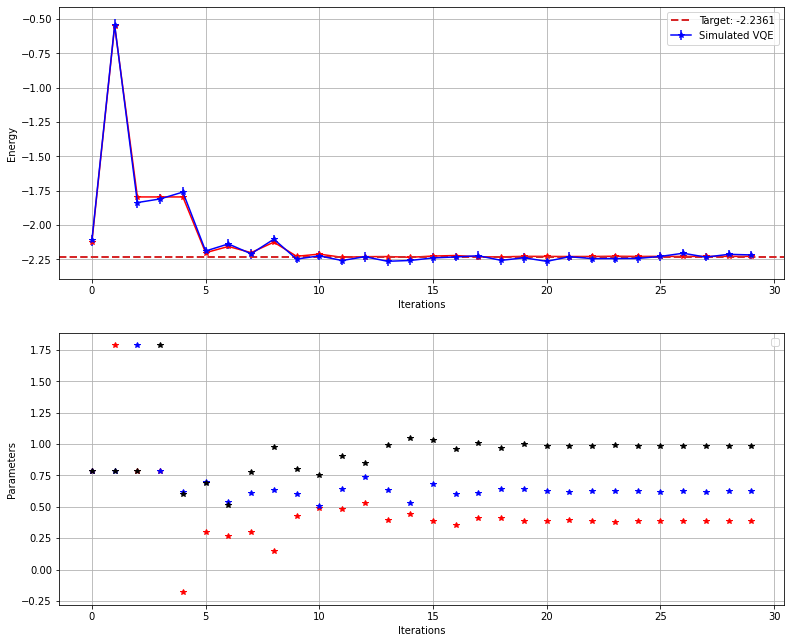

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_2:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.301885
0.019813835714325687


In [17]:
# Define a simple callback function
intermediate_info_real_backend_3= []
def callback(value):
        intermediate_info_real_backend_3.append(value)



start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    #ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=3,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


OrderedDict([('u1', 40), ('u3', 24), ('cx', 16), ('barrier', 2), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 40), ('u3', 24), ('cx', 16), ('barrier', 2), ('u2', 1), ('measure', 1)])
OrderedDict([('measure', 1)])
OrderedDict([('u3', 1), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 36), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 24), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u1', 42), ('u3', 25), ('cx', 16), ('barrier', 2), ('measure', 1)])
OrderedDict([('u

IBMRuntimeError: 'Failed to run program: \'(\\\'Connection aborted.\\\', ConnectionResetError(10054, "Connessione in corso interrotta forzatamente dall\\\'host remoto", None, 10054, None))\''

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


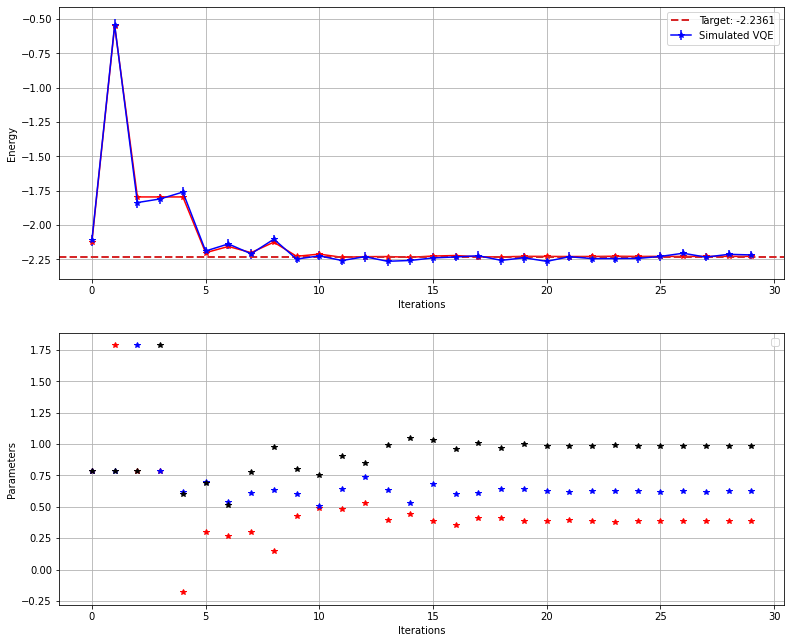

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_2:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.2294400000000003
0.015266216670431834


ideal_energy
-2.083167099839349
miti_energy
-1.761
ideal_energy
-1.5747142562384786
miti_energy
-1.2515
ideal_energy
-2.1022289619069836
miti_energy
-1.7795
ideal_energy
-2.012849689345558
miti_energy
-1.6885
ideal_energy
-0.5657971713640793
miti_energy
-0.502
ideal_energy
-2.178913969850225
miti_energy
-1.7659999999999998
ideal_energy
-2.03821400896334
miti_energy
-1.695
ideal_energy
-2.0948136854329213
miti_energy
-1.697
ideal_energy
-2.1070977943884017
miti_energy
-1.7365000000000002
ideal_energy
-2.0929409890782162
miti_energy
-1.7025
ideal_energy
-2.1721671676708043
miti_energy
-1.787
ideal_energy
-2.1718712186000735
miti_energy
-1.7175
ideal_energy
-2.174223481175702
miti_energy
-1.757
ideal_energy
-2.1703524637980243
miti_energy
-1.784
ideal_energy
-2.1748278155158127
miti_energy
-1.8124999999999998
ideal_energy
-2.1779700840382503
miti_energy
-1.7985
ideal_energy
-2.18129975522006
miti_energy
-1.82
ideal_energy
-2.1893747510258894
miti_energy
-1.807
ideal_energy
-2.181457990025

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ideal_energy
-2.1813682673228723
miti_energy
-1.757
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': None,
    'eigenvalue': -1.82,
    'optimal_circuit': None,
    'optimal_parameters': array([0.26746081, 1.17954716, 0.69214342]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 750.20
[[0.12545909862469554, 0.2049129053202867, 0.706333705090389], [1.1254590986246955, 0.2049129053202867, 0.706333705090389], [0.12545909862469554, 1.2049129053202867, 0.706333705090389], [0.12545909862469554, 1.2049129053202867, 1.706333705090389], [-0.8583342265284138, 1.2406345471560722, 0.5306218452494995], [0.6242179333008723, 1.21192715746523, 0.6718311675125604], [0.04034838030751073, 1.2517431699863462, 0.475979430246531], [0.12545909862469554, 1.327407215627953, 0.7312363945485411], [0.12491071496712122, 0.9659956730550457, 0.7799425048502069], [0.1

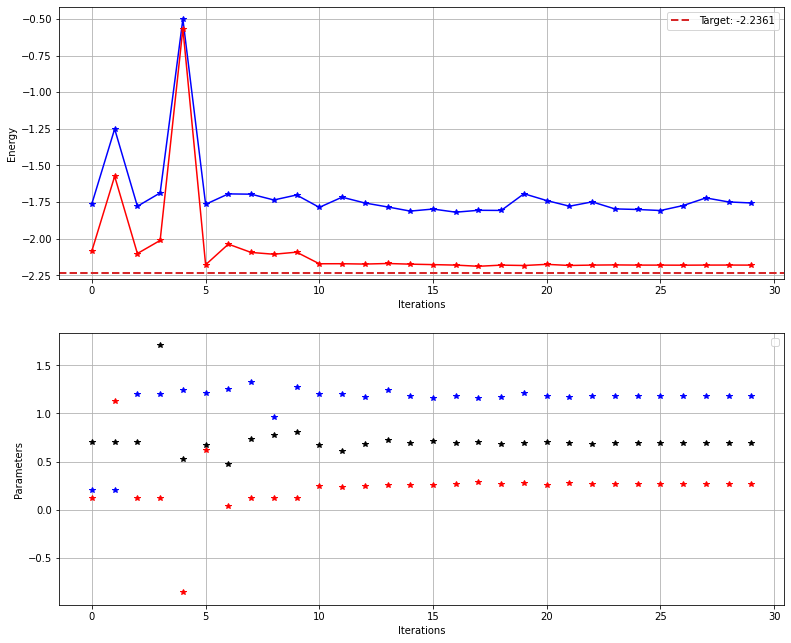

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_raw= []
def callback(value):
        intermediate_info_real_backend_raw.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=[3,5]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_raw:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.770125
0.03046397169491487


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_meas= []
def callback(value):
        intermediate_info_real_backend_meas.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.initial_layout=[3,5]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_meas:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

RuntimeJobFailureError: 'Unable to retrieve job result. Job cga6oecs6g1bb77bm480 has failed:\n2023-03-17T13:38:43.220990784Z Setting up watches.\n2023-03-17T13:38:43.220990784Z Watches established.\n2023-03-17T13:38:44.503318230Z INFO:     Started server process [7]\n2023-03-17T13:38:44.503318230Z INFO:     Waiting for application startup.\n2023-03-17T13:38:44.503460263Z INFO:     Application startup complete.\n2023-03-17T13:38:44.504425581Z INFO:     Uvicorn running on http://127.0.0.1:8081 (Press CTRL+C to quit)\n'

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.155782435344826
0.027874458713609676


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_zne= []
def callback(value):
        intermediate_info_real_backend_zne.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 2
options.optimization_level = 3
options.initial_layout=[3,5]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.9530104166666673
0.03386306568020554


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_PEC= []
def callback(value):
        intermediate_info_real_backend_PEC.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 3
options.optimization_level = 3
options.initial_layout=[1,2]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

ideal_energy
-2.0744645228196776
miti_energy
-2.153311739448268
ideal_energy
-0.7617861014997125
miti_energy
-0.7993497387515204


KeyboardInterrupt: 

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)